# Init Environment

## Note

In [ ]:
# note of the module installations
# install python with pyenv (ref: https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#installing-python-with-pyenv)
# setup virtual environment with pyenv (ref:https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#installing-python-with-pyenv
# error: 'Failed to activate virtualenv' (ref:https://github.com/pyenv/pyenv-virtualenv/issues/387)
# pip install fasttext (0.9.2) (after installing the dependencies: numpy, scipy, pybind11, setuptools, wheel)

# install Jupyter notebook and nbextensions (ref: https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#jupyter-notebook-extensions)
#   pip install jupyter_contrib_nbextensions
#   pip install --upgrade notebook==6.4.12 (ref:https://stackoverflow.com/questions/49647705/jupyter-nbextensions-does-not-appear)
#   pip install traitlets==5.9.0

## Import modules

In [3]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from tqdm import tqdm
import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
from src.helper_text import *
from src.helper_langID import *
from src.helper_translation import *
from src.helper_pred import *

# Combine Data Source

In [ ]:
import glob

# Get a list of file paths that match the pattern
files = glob.glob(f'{DATA_FOLDER_PATH_RAW}/data_202*.xlsx')
# Create an empty list to store DataFrames
dfs = []

# Loop through each file and read it into a DataFrame
for file in files:
    df = pd.read_excel(file, index_col=None)
    dfs.append(df)

# Concatenate the DataFrames into one
df_combined = pd.concat(dfs, ignore_index=True)
df_combined.info()

In [ ]:
#check for null values
df_combined.isnull().sum().sort_values(ascending = False)

In [ ]:
# columns which have large number of null values will be dropped 
columns_to_drop = [
    'Escalated To Engineering', 
    'Bug Type', 
    'Status Reason', 
    'Escalated to L2',
    'Category',
    'Completion Code'
]
try: 
    df_combined.drop(columns_to_drop, axis=1, inplace = True)
    df_combined.dropna(subset=['Request ID'], inplace=True)
    df_combined.dropna(subset=['Product Name'], inplace=True)
    df_combined.dropna(subset=['Title'], inplace=True)
except:
    pass
# surprisingly, there are over 100k duplications
df_combined.drop_duplicates(subset=['Title', 'Product Name'], keep='first', inplace=True)

In [ ]:
df_combined.isnull().sum().sort_values(ascending = False)

In [ ]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_combined.xlsx'

# Export the DataFrame to Excel
df_combined.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

# Load Data for Pre-processing

In [ ]:
data_url = f'{DATA_FOLDER_PATH_PROCESSED}/data_combined.xlsx'
df_combined = pd.read_excel(data_url, index_col=None)
print(df_combined.info())

# Clean-up the Title Column

## Quick Clean-up

In [ ]:
df_processed = df_combined.copy()

df_processed['Length'] = 0
df_processed['Language']=pd.NA
df_processed['Title_Processed']=pd.NA
df_processed['Title_Translated']=pd.NA
df_processed['Title_Cleaned']=pd.NA

# Set the number of rows to process
num = df_processed['Title'].notnull().sum()

# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    # processed_title = preprocess_step_1(df_combined.at[index, 'Title'])
    processed_title = quick_clean_up(df_processed.at[index, 'Title'])
    df_processed.at[index, 'Title_Processed'] = processed_title
    df_processed.at[index, 'Length'] = len(processed_title)
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_processed.index)

# Close the progress bar
progress_bar.close()

In [ ]:
# Delete records with missing values in 'ProductName' columns
df_processed.dropna(subset=['Title_Processed'], inplace=True)
# Remove duplicates based on 'Title' and 'ProductName' columns
df_processed.drop_duplicates(subset=['Title_Processed', 'Product Name'], keep='first', inplace=True)

print(df_processed.info())
hist_by_labels(df_processed, 'Length', log=False)

## Language Detection

In [ ]:
# Set the number of rows to process
num = df_processed['Title_Processed'].notnull().sum()

# df['Title_Translated'] = df['Title_Processed']
# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_processed.at[index, 'Language'] = detect_language_fasttext(df_processed.at[index, 'Title_Processed'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_processed.index)

# Close the progress bar
progress_bar.close()

In [ ]:
# fasttext performance is better than the other solutions for short text 
# (ref: https://medium.com/besedo-engineering/language-identification-for-very-short-texts-a-review-c9f2756773ad

hist_by_labels(df_processed, "Language", log=True, horizontal=True, left=10.5)

In [ ]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_processed.xlsx'

# Export the DataFrame to Excel
df_processed.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

## Translation of Non-English

In [ ]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_processed.xlsx'
df_processed = pd.read_excel(excel_file)

df_translated = df_processed.copy()
df_translated['Title_Translated'] = df_translated['Title_Processed']
print(df_translated.info())

In [ ]:
# Keep the top 10 languages and drop the rest and the unknown. 
# why? There are high chances the detected language were not correct due to wrong spelling, etc.
hist_by_labels(df_processed, "Language", log=True, horizontal=True, left=10.5)

language_counts = df_translated['Language'].value_counts()
cutoff = 99
language_others = language_counts.index[language_counts < cutoff]

mask_others = df_translated['Language'].isin(language_others)
df_translated.loc[mask_others,'Language']='unknown'

# Drop rows where 'Language' is equal to 'unknown'
df_translated = df_translated[df_translated['Language'] != 'unknown']
print(df_translated.info())
hist_by_labels(df_translated, 'Language', log=True, horizontal=True)

In [ ]:
# Group the DataFrame by the "Language" column
grouped = df_translated.groupby("Language")

# Initialize tqdm to display progress bar
pbar = tqdm(total=len(grouped), desc=f"Translating")

# Create an empty list to store the processed groups
processed_groups = []

# Iterate through sub DataFrames
for lang, group in grouped:
    pbar.set_description(f"Processing [{lang}/{len(group)}]")

    translated_titles = translate_array(
        group["Title_Translated"].tolist(),
        src_lang=lang,
        tar_lang='en',
        length_limit=1250)
    group["Title_Translated"] = translated_titles  # Update "Title_Translated" column in the group
    
    processed_groups.append(group)
    pbar.update(1)  # Update the progress bar

# Close the progress bar
pbar.close()

# Concatenate the groups back into a single DataFrame
df_translated = pd.concat(processed_groups, ignore_index=True)

In [ ]:
print(df_translated.isnull().sum().sort_values(ascending = False))

# Delete records with missing values in 'ProductName' columns
df_translated.dropna(subset=['Title_Translated'], inplace=True)
# Remove duplicates based on 'Title' and 'ProductName' columns
df_translated.drop_duplicates(subset=['Title_Translated', 'Product Name'], keep='first', inplace=True)
print(df_translated.info())
hist_by_labels(df_translated, 'Language', log=True, horizontal=True)

In [ ]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'

# Export the DataFrame to Excel
df_translated.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

## Final Clean up

In [ ]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'
df_translated = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})

df_cleaned = df_translated.copy()
print(df_cleaned.info())
print(df_cleaned.info())
df_cleaned.head(10)

In [ ]:
df_cleaned.drop(columns=[
    'Created Time', 
    'Customer Company', 'Customer Country', 
    'Priority', 'Urgency', 'Impact', 
    'Service Definition', 'Service Desk Group', 'Status',
    'Closed Time', 
    'Response Time (Min)', 'Resolution Time (Min)', 
    'Contracts Reference', 'Creation Source'
    ], inplace=True)

# Set the number of rows to process
num = df_cleaned['Title_Translated'].notnull().sum()

# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_cleaned.at[index, 'Title_Cleaned'] = final_clean_up(df_cleaned.at[index, 'Title_Translated'])
    df_cleaned.at[index, 'Length'] = count_words(df_cleaned.at[index, 'Title_Cleaned'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_cleaned.index)

# Close the progress bar
progress_bar.close()

print(df_cleaned.info())

In [ ]:
# Remove duplicates based on 'Title' and 'ProductName' columns after translation
df_cleaned.dropna(subset=['Title_Cleaned'], inplace=True)
df_cleaned.drop_duplicates(subset=['Title_Cleaned', 'Product Name'], keep='first', inplace=True)
print(df_cleaned.info())

# remove the same title pointing to multiple products
n_title = df_cleaned['Title_Cleaned'].value_counts()
good_title = n_title.index[n_title == 1]
print (len(good_title))

mask = df_cleaned['Title_Cleaned'].isin(good_title)
df_cleaned = df_cleaned[mask]
print(df_cleaned.info())
print(df_cleaned.isnull().sum().sort_values(ascending = False))

In [ ]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'

# Export the DataFrame to Excel
df_cleaned.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

# Consolidate Product Categories

In [13]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
df_cleaned = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121270 entries, 0 to 121269
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        121270 non-null  object
 1   Title             121270 non-null  object
 2   Product Name      121270 non-null  object
 3   Module Name       114420 non-null  object
 4   Length            121270 non-null  int64 
 5   Language          121270 non-null  object
 6   Title_Processed   121270 non-null  object
 7   Title_Translated  121270 non-null  object
 8   Title_Cleaned     121270 non-null  object
dtypes: int64(1), object(8)
memory usage: 8.3+ MB
None


In [19]:
df_consolidated = df_cleaned.copy()
df_consolidated.head(10)

,Request ID,Title,Product Name,Module Name,Length,Language,Title_Processed,Title_Translated,Title_Cleaned
0,1136751,data exchanger with client,Petrel,Geology,2,en,data exchanger with client,data exchanger with client,data exchanger
1,1140517,"Error: Unable to start external queue, but run...",Petrel RE,RE - Other,4,en,Error Unable to start external queue but runni...,Error Unable to start external queue but runni...,start queue running locally
2,1144906,unable to run simulation jobs on the cluster,Simulation Cluster Manager,Load Sharing Facility (LFS),3,en,unable to run simulation jobs on the cluster,unable to run simulation jobs on the cluster,simulation job cluster
3,1146411,Collocated co-kriging incertidumbre,Petrel,Geology,4,en,Collocated co kriging incertidumbre,Collocated co kriging incertidumbre,collocated co kriging incertidumbre
4,1154418,Access a new Studio 2020 Connection Issue,Studio,Studio Petrel,4,en,Access a new Studio Connection Issue,Access a new Studio Connection Issue,access studio connection issue
5,1155301,[Ext] boundary for pillar griding,Petrel,Modeling,3,en,Ext boundary for pillar griding,Ext boundary for pillar griding,boundary pillar griding
6,1160111,RE: [Ext] Re: Issue with OFM,OFM,Base,2,en,RE Ext Re Issue with OFM,RE Ext Re Issue with OFM,issue ofm
7,1160303,Algeria --> SH PED --> RE: [Ext] Re: Issue wit...,OFM,Base,5,en,Algeria SH PED RE Ext Re Issue with OFM,Algeria SH PED RE Ext Re Issue with OFM,algeria sh ped issue ofm
8,1161943,OFM License issue at Well Test Department - SH...,OFM,Base,10,en,OFM License issue at Well Test Department SH D...,OFM License issue at Well Test Department SH D...,ofm license issue well test department sh dp h...
9,1167773,Cases deleted from .sim folder but not from Ca...,Petrel RE,RE - Other,6,en,Cases deleted from sim folder but not from Cas...,Cases deleted from sim folder but not from Cas...,case deleted sim folder case pane


In [20]:
dict_category_mapping = {
    'Others': ['Other'],
    'Studio': ['Ocean Framework for Studio'],
    'Techlog': ['Ocean Framework for Techlog'],
    'PIPESIM, IAM': ['PIPESIM', 'Integrated Asset Modeler'],
    'Omega, VISTA, OMNI3D': ['Omega', 'OMEGA', 'VISTA', 'OMNI3D'],
    'ProSource, InnerLogix': ['ProSource', 'EXP_PS', 'InnerLogix'],
    'ProdOps, Avocet, PDF': ['Production Data Foundation', 'Avocet'],
    'Engine Ecosystem, Sim Cluster Mgr.': ['Engine Ecosystem', 'Simulation Cluster Manager'],
    'Petrel': ['Petrel Exploration Geology', 'Petrel Project Explorer', 'Ocean Framework for Petrel', 'Ocean Plug-ins for Petrel - SLB'],
    'Storage, File Management, Secure Data Exchange': ['Storage', 'Nasuni', 'File Management', 'Secure Data Exchange'],
    'Delfi Portal': ['Delfi Portal', 'SAuth', 'License', 'Licensing', 'Environment', 'Authorization', 'VM', 'TGX', 'Remote App'],
    'RE (Petrel RE, DELFI RE, ECLIPSE, INTERSECT, ODRS, FluidModeler)': ['Petrel RE', 'DELFI RE', 'ECLIPSE', 'INTERSECT', 'On Demand Reservoir Simulation', 'FluidModeler'],
    
    '3rd Party': ['Ocean Plug-ins for Petrel - Third party', 'Ocean Plug-ins for Petrel - Third Party',
                '3rd party application', 'Third-Party Applications', 'Ocean Plug-ins for Techlog - Third Party', 
                'App – Third Party', 'App - Third Party'],
    
    'Deployment': ['Provisioning & Decommissioning', 'Software Demo and Evaluation', 'Internal Deployment', 'Image', 
                'Deployment Status', "New PTS Deployment", 'Remove PTS Deployment', 'System Deployment', 'Deployment',
                'Cloud Project Creation', 'Cloud Project Maintenance', 'Tenant Maintenance', 'DNS Management',
                'CCM - Contract Management', 'CCM - Catalog Management', 'Software and Solution Quotation']
}
# Use Module Name to replace Product Name for all 'Petrotechnical Suite - Domain Profiles'
df_consolidated.loc[df_consolidated['Product Name'] == 'Petrotechnical Suite - Domain Profiles', 'Product Name'] = df_consolidated['Module Name']
df_consolidated.drop(columns=['Module Name'], inplace=True)
df_consolidated.dropna(subset=['Product Name'], inplace=True)

# combine the following products into corresponding categories
for category, products in dict_category_mapping.items():
    df_consolidated.loc[df_consolidated['Product Name'].isin(products), 'Product Name'] = category

#drop the rows which Product Name is 'Quality and Feedback' and 'Software Training Services'
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Delfi Help']
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Quality and Feedback']
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Software Training Services']

#Drop the products which have less than 50 records
df_consolidated = df_consolidated.groupby('Product Name').filter(lambda x : len(x)>50)

print(df_consolidated.info())

<class 'pandas.core.frame.DataFrame'>
Index: 119833 entries, 0 to 121269
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        119833 non-null  object
 1   Title             119833 non-null  object
 2   Product Name      119833 non-null  object
 3   Length            119833 non-null  int64 
 4   Language          119833 non-null  object
 5   Title_Processed   119833 non-null  object
 6   Title_Translated  119833 non-null  object
 7   Title_Cleaned     119833 non-null  object
dtypes: int64(1), object(7)
memory usage: 8.2+ MB
None


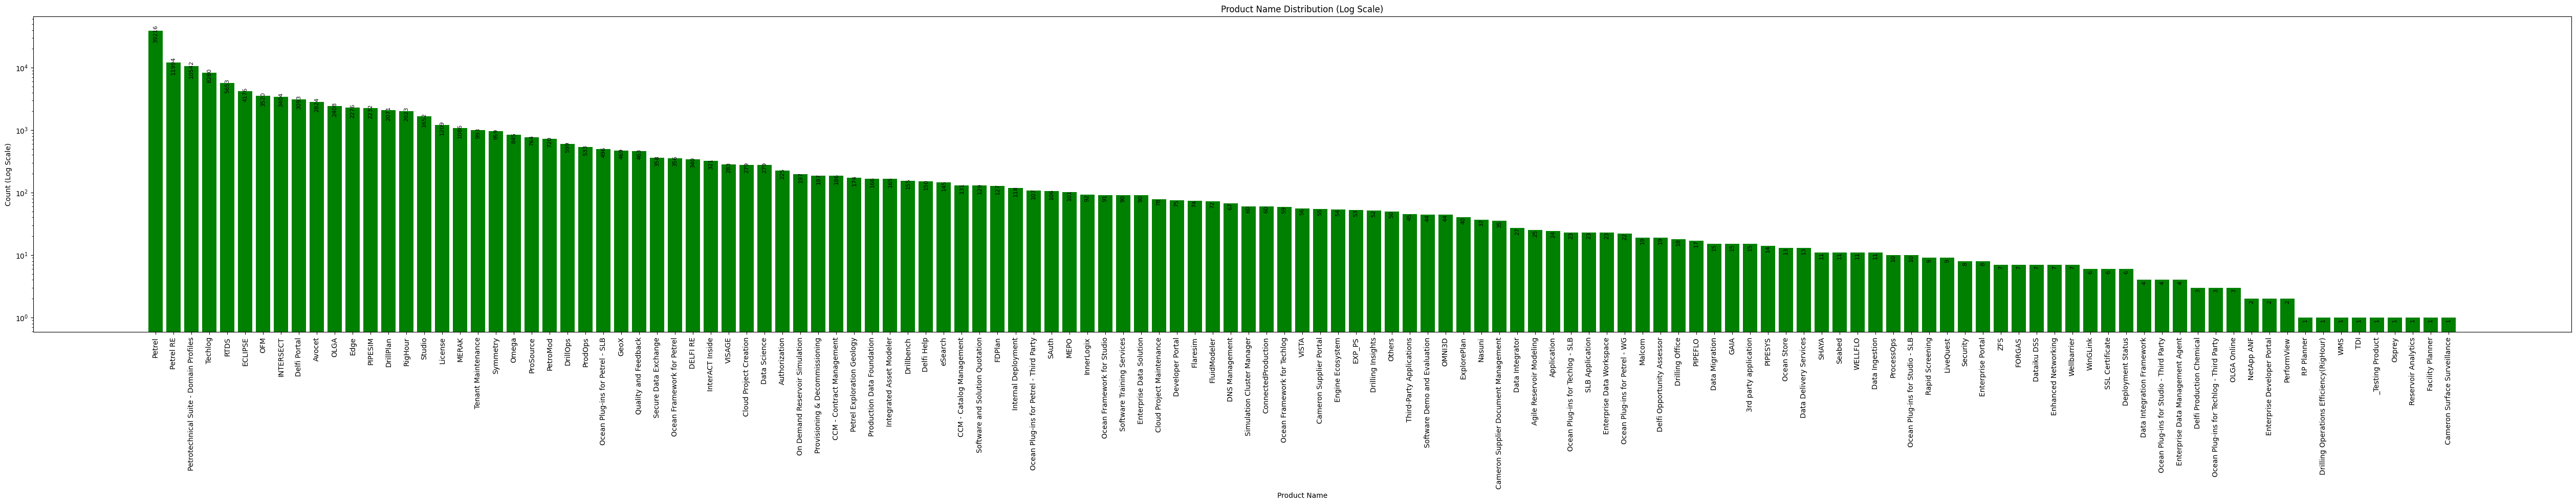

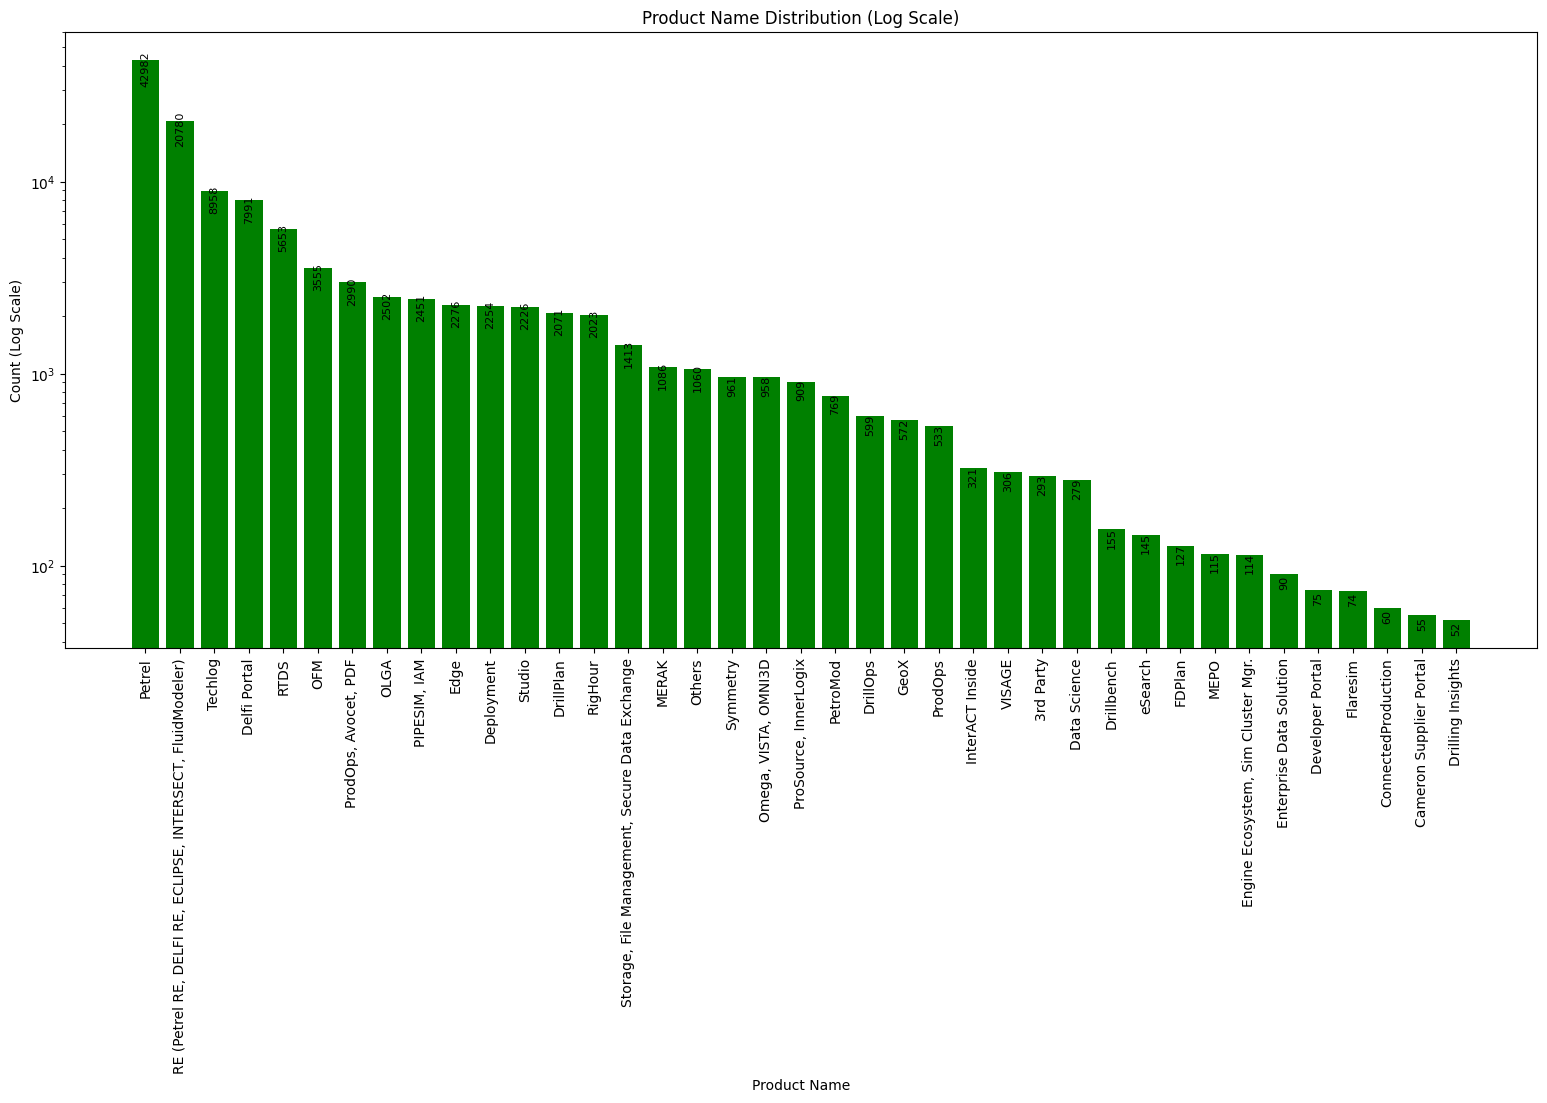

In [17]:
hist_by_labels(df_cleaned, 'Product Name', log=True, horizontal=True)
hist_by_labels(df_consolidated, 'Product Name', top=None, log=True, horizontal=True)

In [18]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_consolidated.xlsx'

# Export the DataFrame to Excel
df_consolidated.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

# Data Augmentation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119833 entries, 0 to 119832
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        119833 non-null  object
 1   Title             119833 non-null  object
 2   Product Name      119833 non-null  object
 3   Length            119833 non-null  int64 
 4   Language          119833 non-null  object
 5   Title_Processed   119833 non-null  object
 6   Title_Translated  119833 non-null  object
 7   Title_Cleaned     119833 non-null  object
dtypes: int64(1), object(7)
memory usage: 7.3+ MB
None


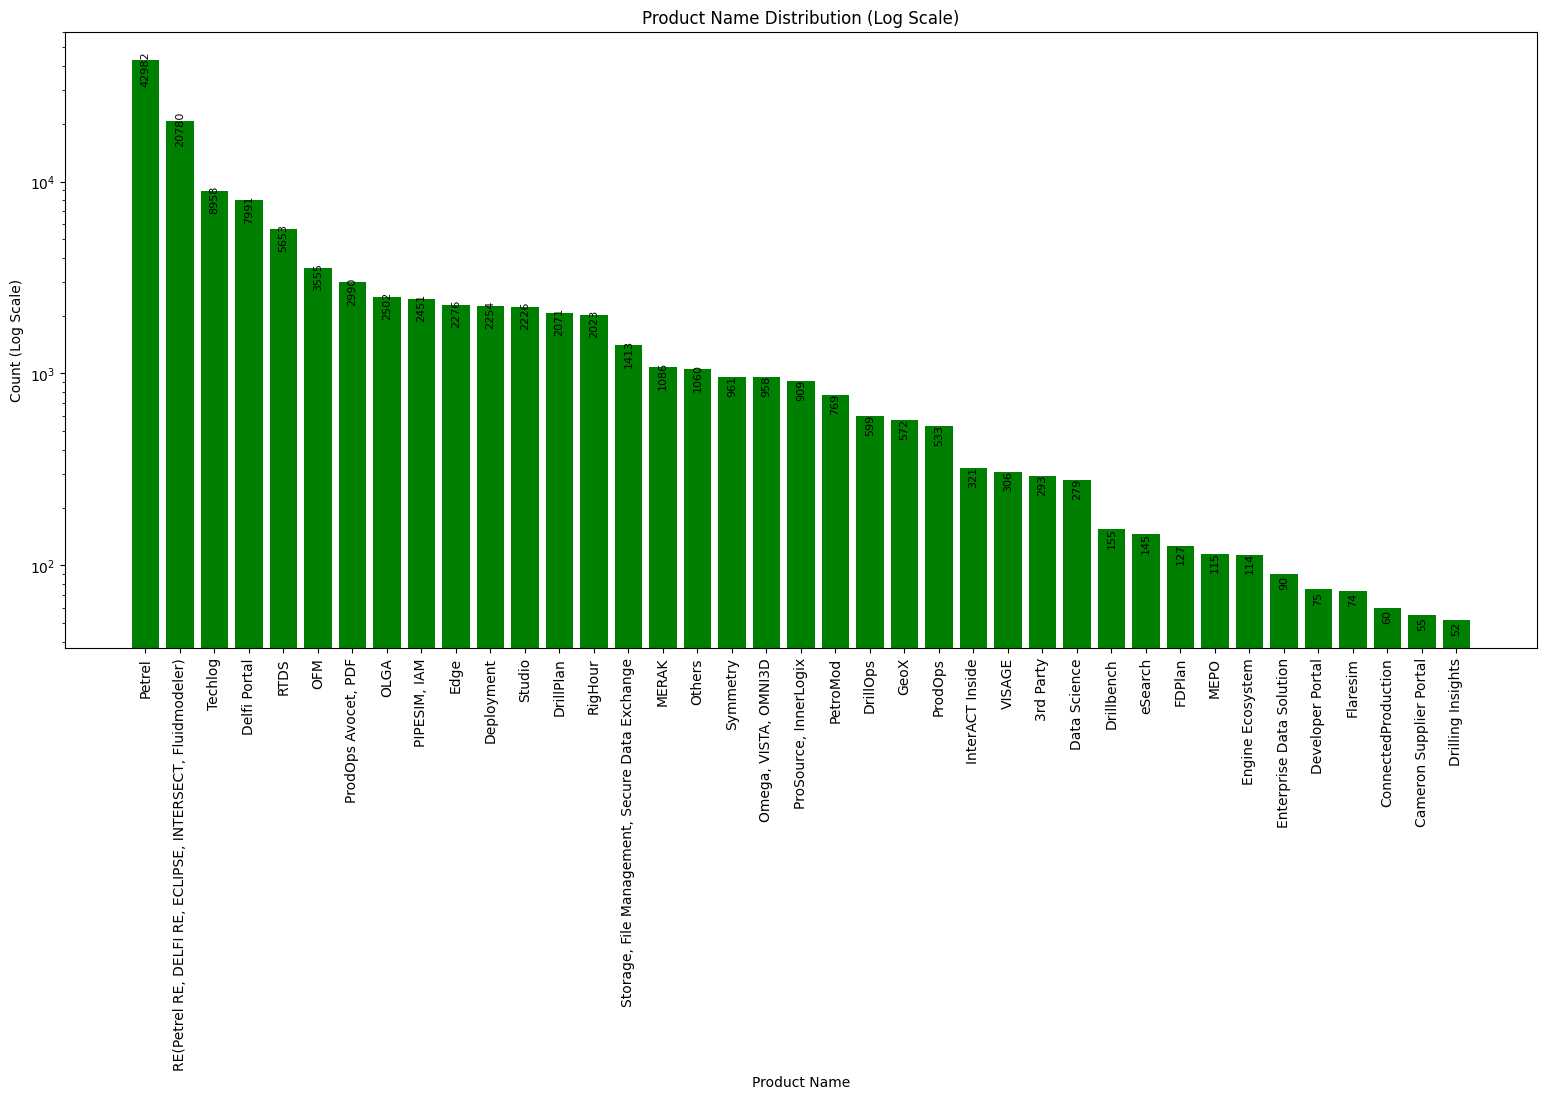

In [26]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_consolidated.xlsx'

df_consolidated = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})
print(df_consolidated.info())
hist_by_labels(df_consolidated, 'Product Name', top=None, log=True, horizontal=True)

In [27]:
# function to augment a dataframe with a given product name
def augment_product_data(df, target_size=500):

    result = pd.DataFrame(columns=df.columns)
    
    df_size = len(df)
    lang_agent = ['fr', 'ja', 'ru', 'es', 'ko', 'zh', 'pt', 'ar', 'de', 'it']
    
    num_iterations = min(target_size // df_size-1, len(lang_agent))
    
    for i in range(num_iterations):
        df_temp = df.copy()
        translated_titles = df_temp["Title_Translated"].tolist()
        translated_titles = translate_array(translated_titles, src_lang='en', tar_lang=lang_agent[i],length_limit=1250)
        translated_titles = translate_array(translated_titles, src_lang=lang_agent[i], tar_lang='en',length_limit=1250)

        df_temp['Title_Translated'] = translated_titles
        result = pd.concat([result, df_temp], ignore_index=True)
    return result

TARGET_SIZE = 5000
df_augmented = pd.DataFrame(columns=df_consolidated.columns)

# filter the products which have less than 2500 records
grouped = df_consolidated.groupby("Product Name")
# grouped = grouped.filter(lambda x : len(x)>2500)

# Initialize tqdm to display progress bar
pbar = tqdm(total=len(grouped), desc=f"Processing")

# Create an empty list to store the processed groups
processed_groups = []

# Iterate through sub DataFrames
for product, group in grouped:
    if (len(group) > TARGET_SIZE//2):
        pbar.update(1)  # Update the progress bar
        continue
    pbar.set_description(f"Processing [{product}/{len(group)}]")
    df_product = augment_product_data(group, target_size=TARGET_SIZE)

    processed_groups.append(df_product)
    pbar.update(1)  # Update the progress bar
# Close the progress bar
pbar.close()

# Concatenate the groups back into a single DataFrame
df_additional = pd.concat(processed_groups, ignore_index=True)
df_augmented = pd.concat([df_consolidated, df_additional], ignore_index=True)

df_augmented['Title_Cleaned'] = df_augmented['Title_Translated'].apply(final_clean_up)
df_augmented.dropna(subset=['Title_Cleaned'], inplace=True)
df_augmented['Length'] = df_augmented['Title_Cleaned'].apply(count_words)
df_augmented.drop_duplicates(subset=['Title_Cleaned', 'Product Name'], keep='first', inplace=True)

Processing [eSearch/145]: 100%|██████████| 39/39 [29:45<00:00, 45.78s/it]


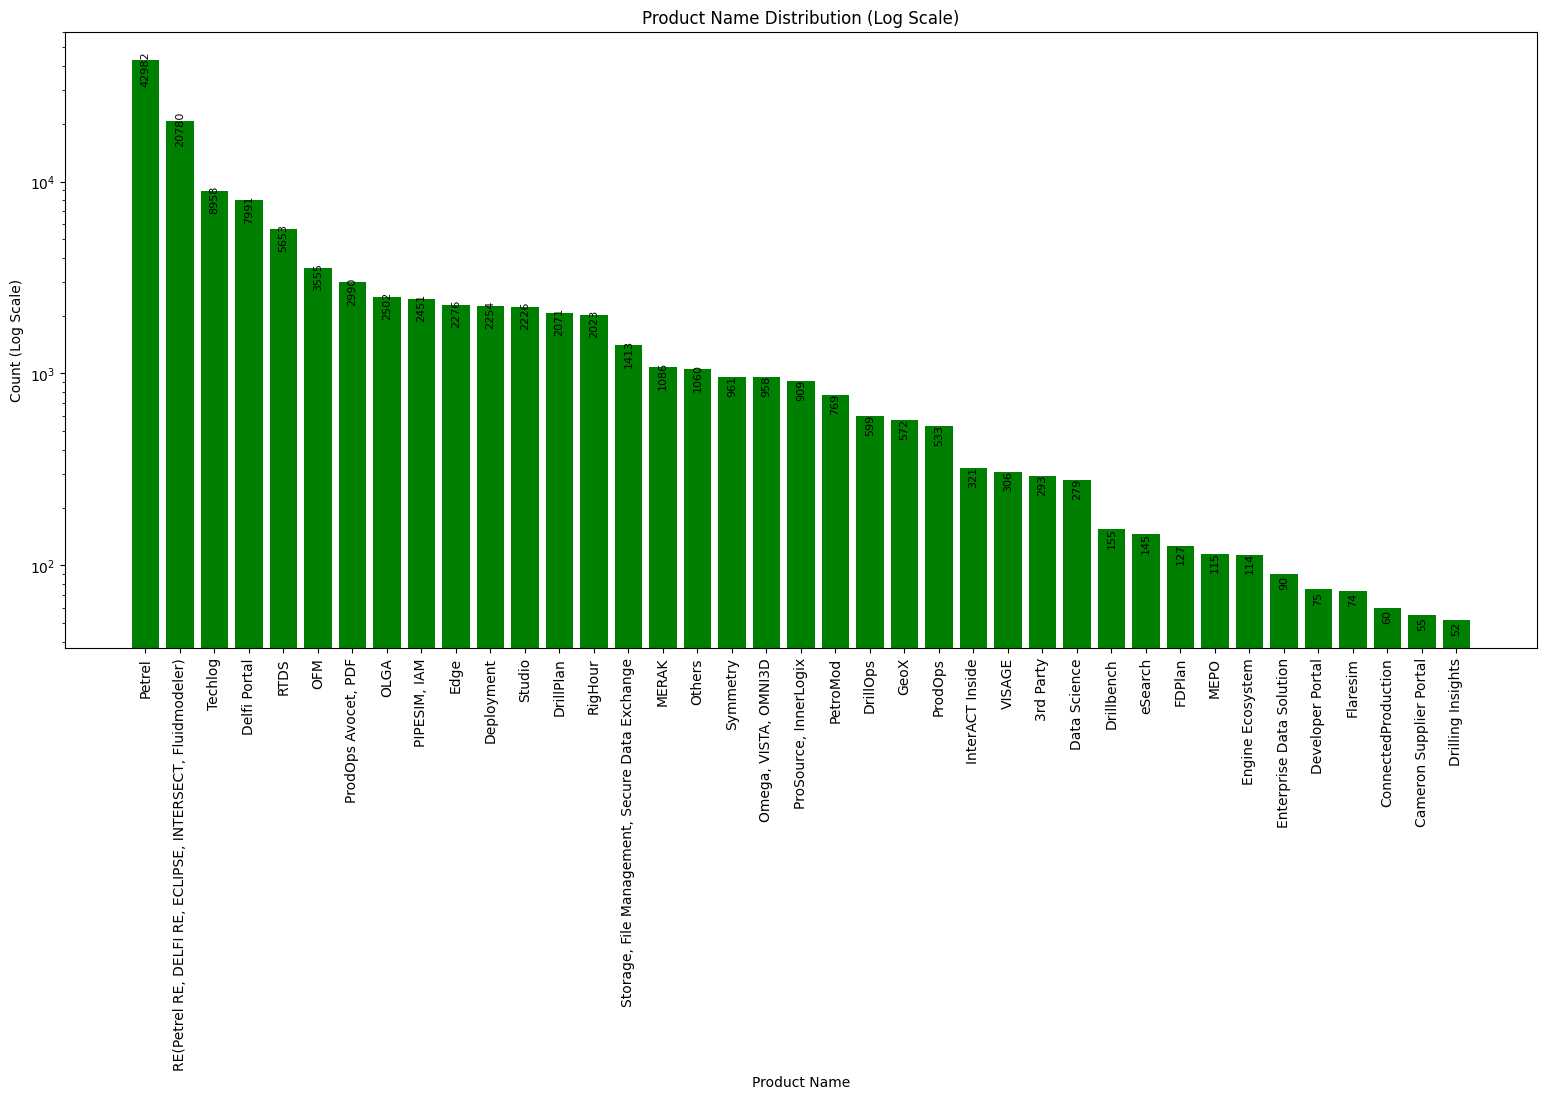

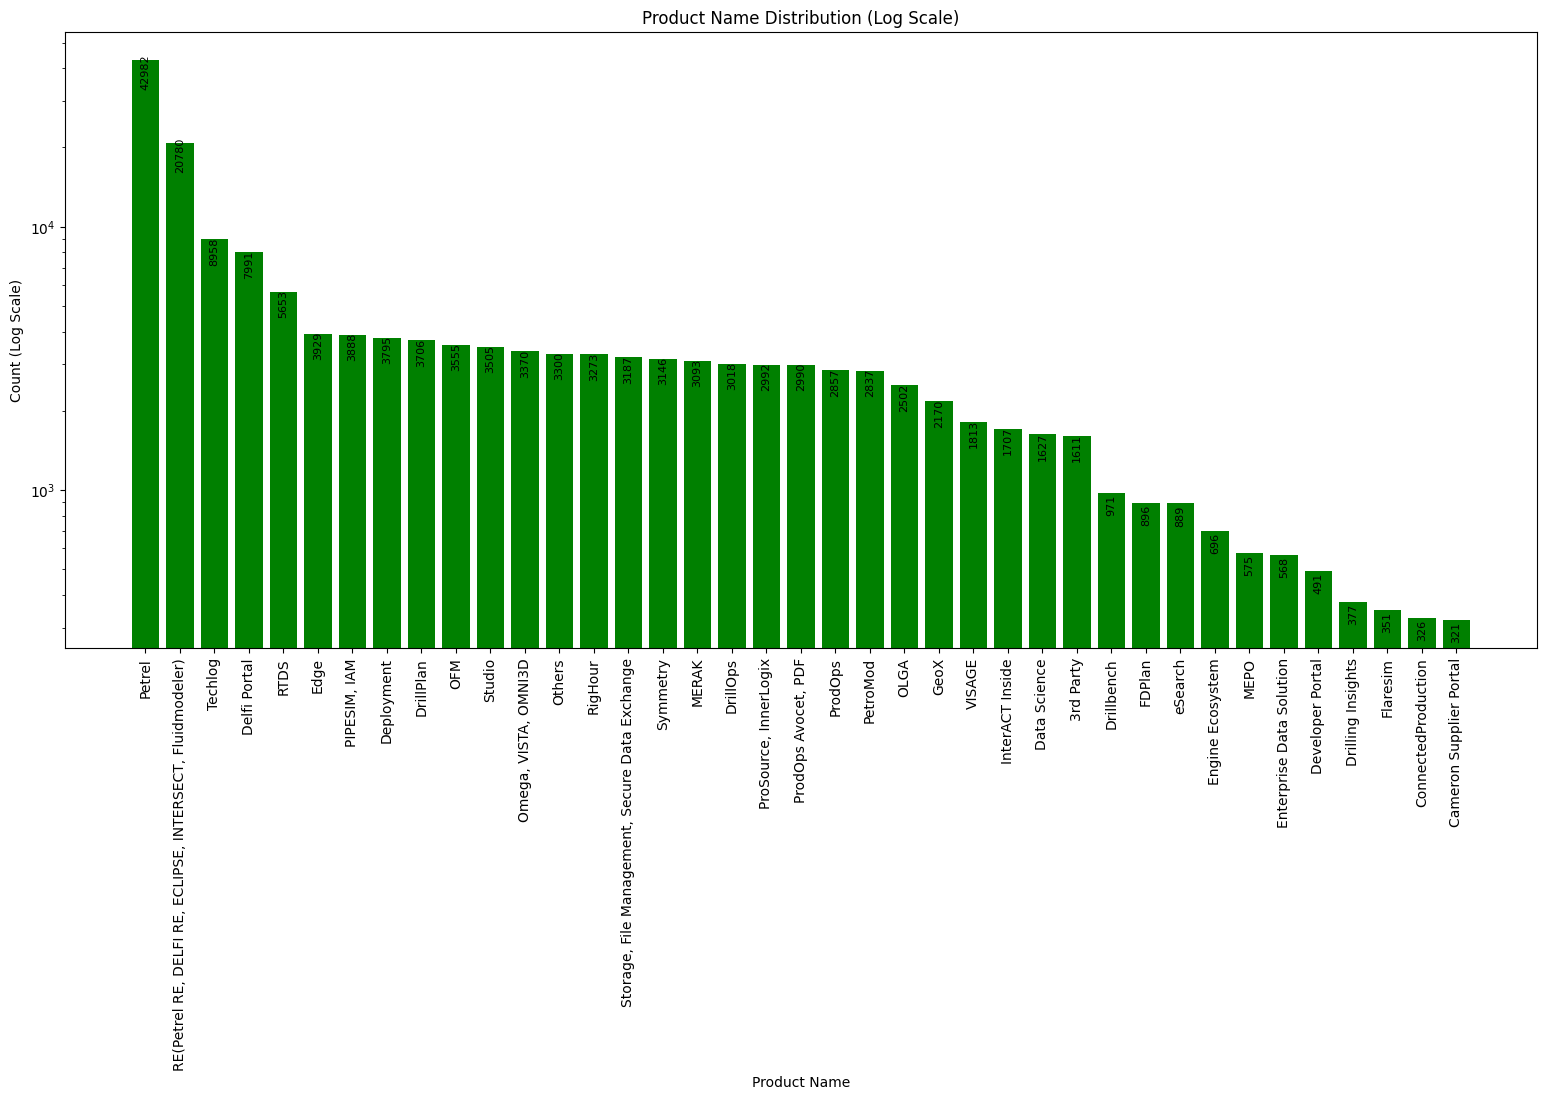

In [28]:
hist_by_labels(df_consolidated, 'Product Name', top=None, log=True, horizontal=True)
hist_by_labels(df_augmented, 'Product Name', top=None, log=True, horizontal=True)

In [ ]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_augmented.xlsx'

# Export the DataFrame to Excel
df_augmented.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index